In this file, the goal is to study the latent space of PEPR_Marseille using some anomalies detection method after residualizing

In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Embeddings_UKB= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/epilepsy_PBS/Embeddings.csv")
Embeddings_PEPR= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/PEPR_Marseille/Embeddings.csv")

In [3]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [4]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]

In [5]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})

In [6]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")

In [7]:
X1 = Embeddings_UKB.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_PEPR.iloc[:,1:76]

In [8]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)

In [9]:
import statsmodels.api as sm

In [10]:
L= np.concatenate((X1,X2,X3,X4), axis=0)

covariates = pd.DataFrame({
    'Site': ['UKB']*len(X1) 
            + ['hcp']*len(X2) 
            + ['epilepsy_PBS']*len(X3) 
            + ['PEPR']*len(X4)
})

In [11]:
covariates

,Site
0,UKB
1,UKB
2,UKB
3,UKB
4,UKB
...,...
44596,PEPR
44597,PEPR
44598,PEPR
44599,PEPR


In [12]:
covariates = pd.get_dummies(covariates)
covariates

,Site_PEPR,Site_UKB,Site_epilepsy_PBS,Site_hcp
0,False,True,False,False
1,False,True,False,False
2,False,True,False,False
3,False,True,False,False
4,False,True,False,False
...,...,...,...,...
44596,True,False,False,False
44597,True,False,False,False
44598,True,False,False,False
44599,True,False,False,False


In [13]:
covariates_train= covariates.head(len(X1)+len(X2)+len(X3))
covariates_test= covariates.tail(len(X4))

L_train=np.concatenate((X1,X2,X3), axis=0)
L_test= X4

In [14]:
covariates = sm.add_constant(covariates)  # Add intercept

L1_resid = np.zeros_like(L_train)
L2_resid = np.zeros_like(L_test)

for j in range(L_train.shape[1]):
    model = sm.OLS(L_train[:, j].astype(float), covariates_train.astype(float)).fit()
    L1_resid[:, j] = model.resid 
    L2_resid[:, j] = L_test[:,j] - model.predict(covariates_test)


In [15]:
X_ukb = L1_resid[:len(X1),:]
X_hcp = L1_resid[len(X1):len(X1)+len(X2),:]
X_control= L1_resid[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
X_PEPR= L2_resid

In [16]:
def proportion_positive(L):
    n_total = len(L)
    n_pos = np.sum(L == 1)

    return n_pos / n_total

One-class SVM

In [17]:
from sklearn.svm import OneClassSVM

In [18]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X_ukb)

    y1 = clf.predict(X_ukb)
    y2 = clf.predict(X_hcp)
    y3 = clf.predict(X_control)
    y4 = clf.predict(X_PEPR)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


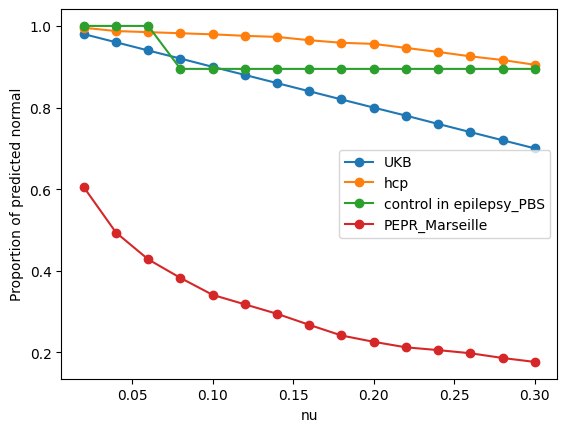

In [19]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Isolation forest

In [20]:
from sklearn.ensemble import IsolationForest

In [21]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:
    print(a)
    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X_ukb)

    y1 = clf.predict(X_ukb)
    y2 = clf.predict(X_hcp)
    y3 = clf.predict(X_control)
    y4 = clf.predict(X_PEPR)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


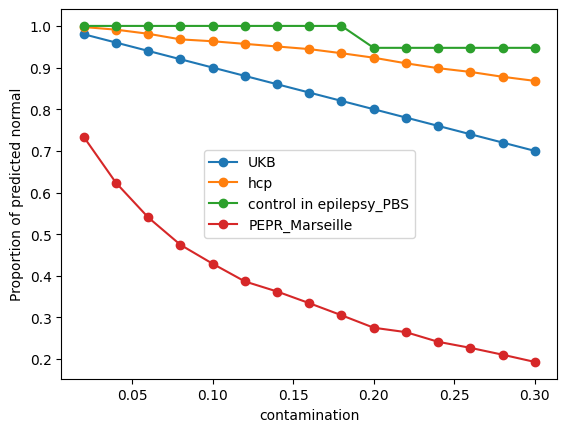

In [22]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

LOF

In [23]:
from sklearn.neighbors import LocalOutlierFactor

In [24]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X_ukb)
    y1 = lof.predict(X_ukb)
    y2 = lof.predict(X_hcp)
    y3 = lof.predict(X_control)
    y4 = lof.predict(X_PEPR)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

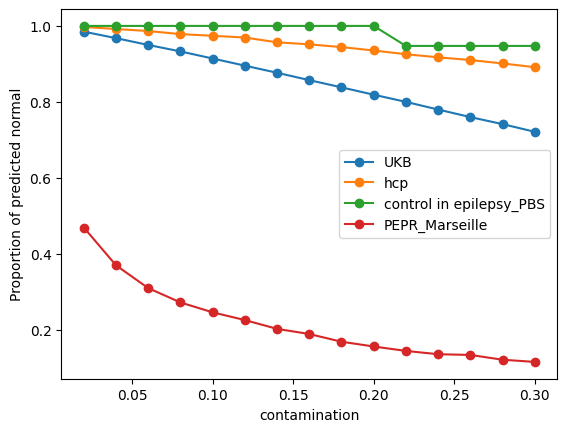

In [25]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

ABOD

In [26]:
from pyod.models.abod import ABOD

In [27]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X_ukb)

    y1 =1-  clf.predict(X_ukb)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X_hcp)
    y3 = 1- clf.predict(X_control)
    y4 = 1-  clf.predict(X_PEPR)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


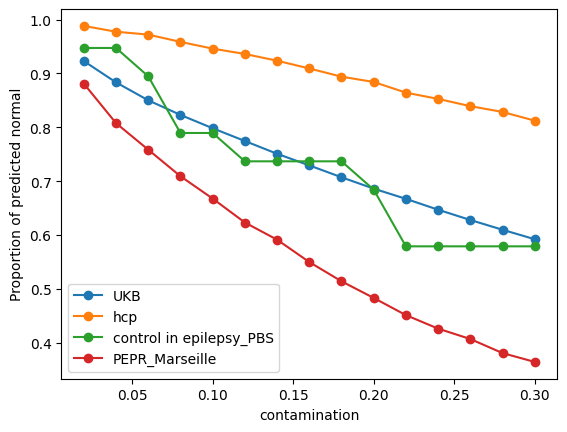

In [28]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 2D

In [29]:
reducer = umap.UMAP(n_components=2, random_state=42)
X1_umap2 = reducer.fit_transform(X_ukb)
X2_umap2 = reducer.transform(X_hcp)
X3_umap2= reducer.transform(X_control)
X4_umap2=reducer.transform(X_PEPR)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [30]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


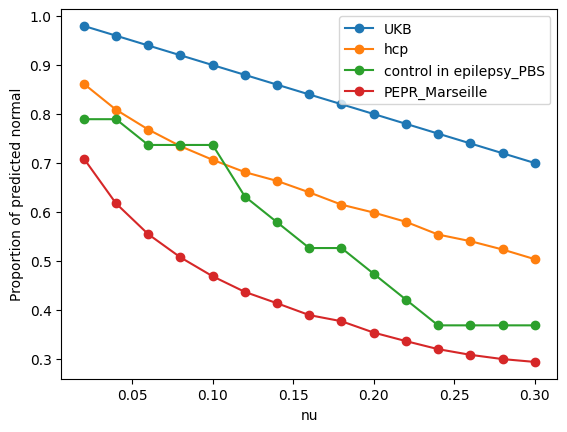

In [31]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [32]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

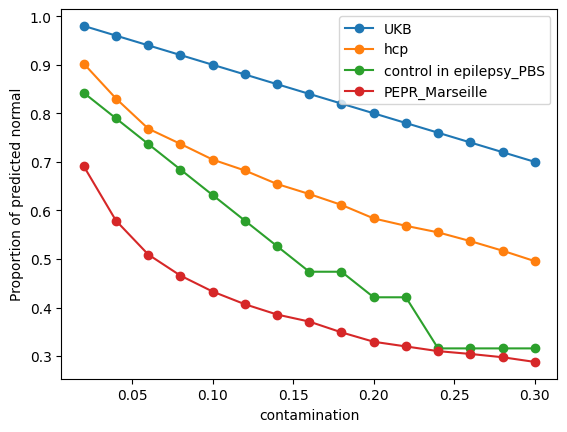

In [33]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [34]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap2)
    y1 = lof.predict(X1_umap2)
    y2 = lof.predict(X2_umap2)
    y3 = lof.predict(X3_umap2)
    y4 = lof.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

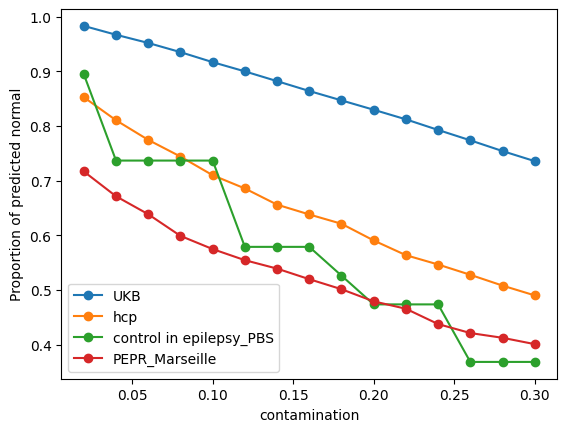

In [35]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [36]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap2)

    y1 =1-  clf.predict(X1_umap2)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap2)
    y3 = 1- clf.predict(X3_umap2)
    y4 = 1-  clf.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


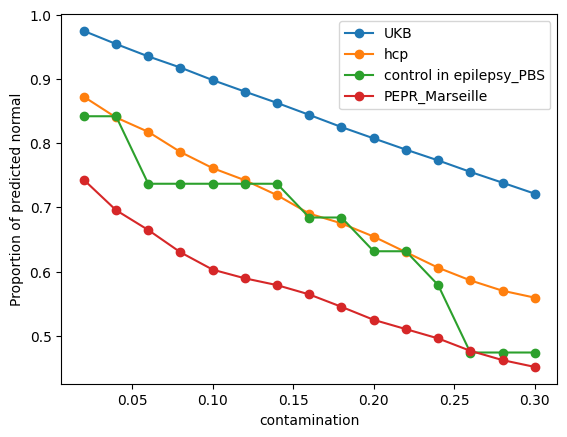

In [37]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 5D

In [38]:
reducer = umap.UMAP(n_components=5, random_state=42)
X1_umap5 = reducer.fit_transform(X_ukb)
X2_umap5 = reducer.transform(X_hcp)
X3_umap5= reducer.transform(X_control)
X4_umap5=reducer.transform(X_PEPR)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [39]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap5)

    y1 = clf.predict(X1_umap5)
    y2 = clf.predict(X2_umap5)
    y3 = clf.predict(X3_umap5)
    y4 = clf.predict(X4_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


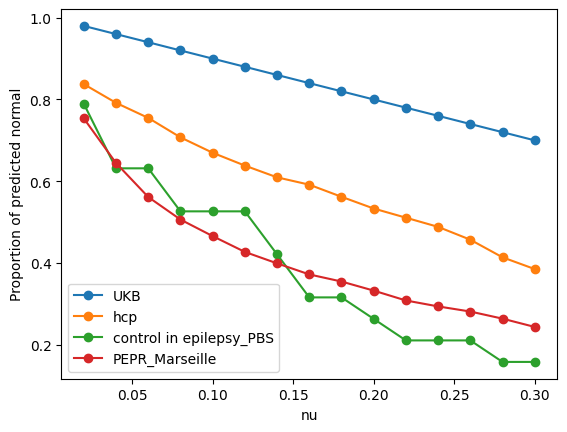

In [40]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [41]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap5)

    y1 = clf.predict(X1_umap5)
    y2 = clf.predict(X2_umap5)
    y3 = clf.predict(X3_umap5)
    y4 = clf.predict(X4_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

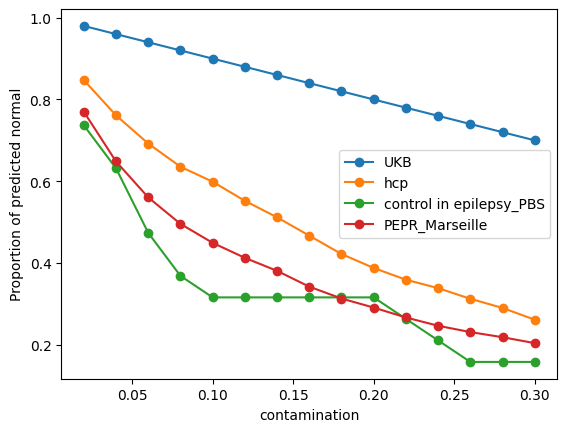

In [42]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [43]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap5)
    y1 = lof.predict(X1_umap5)
    y2 = lof.predict(X2_umap5)
    y3 = lof.predict(X3_umap5)
    y4 = lof.predict(X4_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

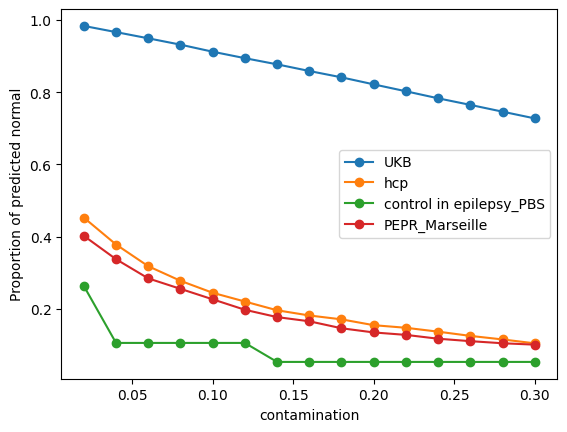

In [44]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [45]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []


for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap5)

    y1 =1-  clf.predict(X1_umap5)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap5)
    y3 = 1- clf.predict(X3_umap5)
    y4 = 1-  clf.predict(X4_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


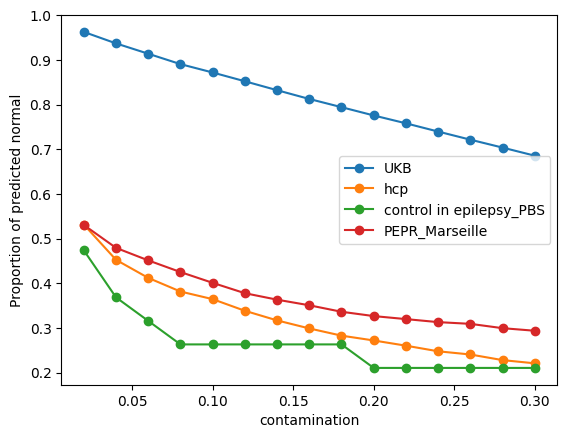

In [46]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 10D

In [47]:
reducer = umap.UMAP(n_components=10, random_state=42)
X1_umap10 = reducer.fit_transform(X_ukb)
X2_umap10 = reducer.transform(X_hcp)
X3_umap10= reducer.transform(X_control)
X4_umap10=reducer.transform(X_PEPR)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [48]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap10)

    y1 = clf.predict(X1_umap10)
    y2 = clf.predict(X2_umap10)
    y3 = clf.predict(X3_umap10)
    y4 = clf.predict(X4_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


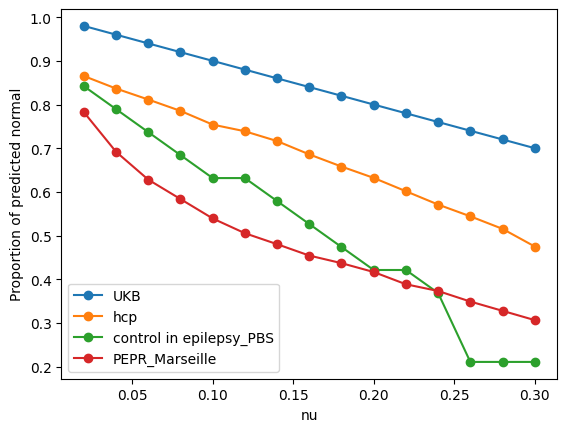

In [49]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [50]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap10)

    y1 = clf.predict(X1_umap10)
    y2 = clf.predict(X2_umap10)
    y3 = clf.predict(X3_umap10)
    y4 = clf.predict(X4_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

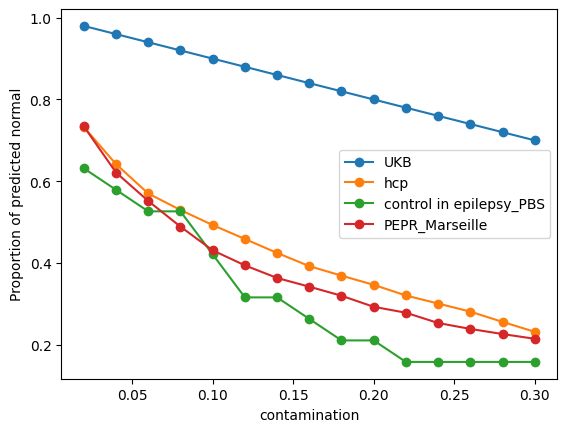

In [51]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [52]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap10)
    y1 = lof.predict(X1_umap10)
    y2 = lof.predict(X2_umap10)
    y3 = lof.predict(X3_umap10)
    y4 = lof.predict(X4_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

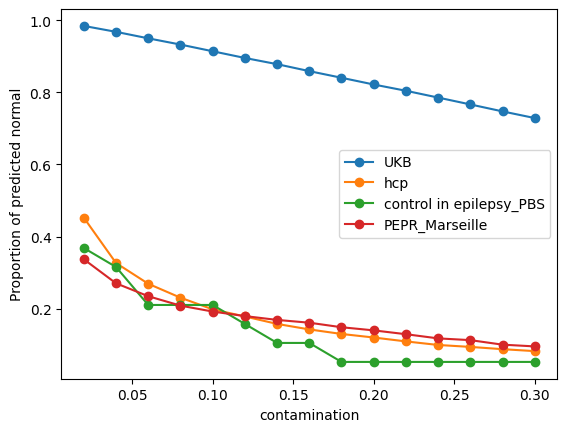

In [53]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [54]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap10)

    y1 =1-  clf.predict(X1_umap10)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap10)
    y3 = 1- clf.predict(X3_umap10)
    y4 = 1-  clf.predict(X4_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


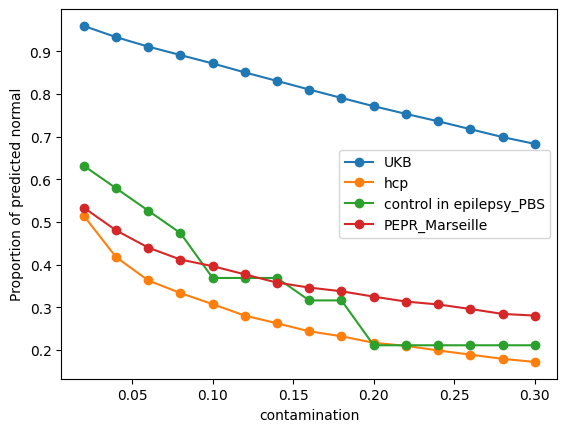

In [55]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 20D

In [108]:
reducer = umap.UMAP(n_components=20, random_state=42)
X1_umap20 = reducer.fit_transform(X_ukb)
X2_umap20 = reducer.transform(X_hcp)
X3_umap20= reducer.transform(X_control)
X4_umap20=reducer.transform(X_neg)
X5_umap20=reducer.transform(X_pos)
X6_umap20=reducer.transform(X_cs)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [109]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap20)

    y1 = clf.predict(X1_umap20)
    y2 = clf.predict(X2_umap20)
    y3 = clf.predict(X3_umap20)
    y4 = clf.predict(X4_umap20)
    y5 = clf.predict(X5_umap20)
    y6 = clf.predict(X6_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


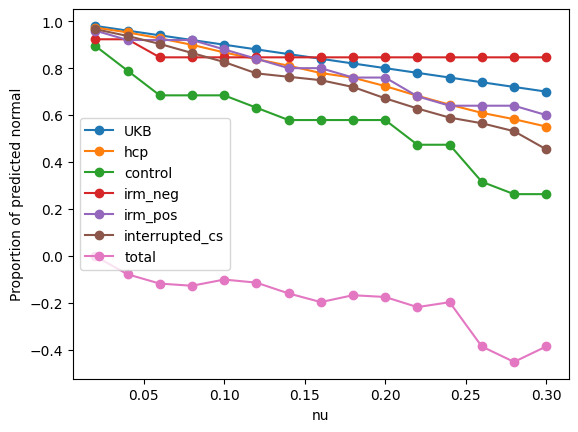

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [111]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap20)

    y1 = clf.predict(X1_umap20)
    y2 = clf.predict(X2_umap20)
    y3 = clf.predict(X3_umap20)
    y4 = clf.predict(X4_umap20)
    y5 = clf.predict(X5_umap20)
    y6 = clf.predict(X6_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)

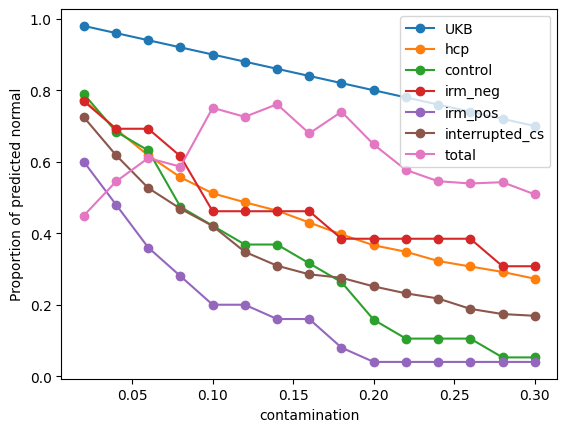

In [112]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [113]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap20)
    y1 = lof.predict(X1_umap20)
    y2 = lof.predict(X2_umap20)
    y3 = lof.predict(X3_umap20)
    y4 = lof.predict(X4_umap20)
    y5 = lof.predict(X5_umap20)
    y6 = lof.predict(X6_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


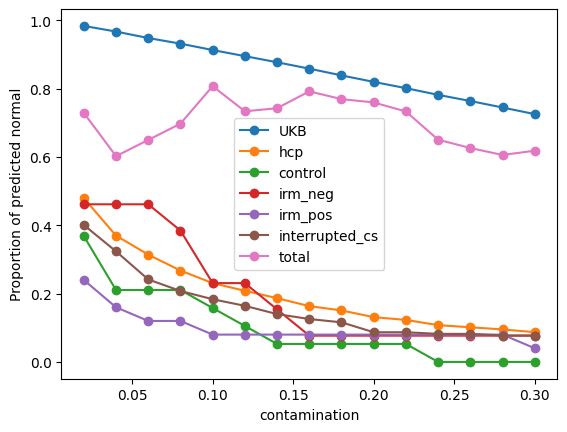

In [114]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [115]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []


for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap20)

    y1 =1-  clf.predict(X1_umap20)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap20)
    y3 = 1- clf.predict(X3_umap20)
    y4 = 1- clf.predict(X4_umap20)
    y5 = 1- clf.predict(X5_umap20)
    y6 = 1- clf.predict(X6_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


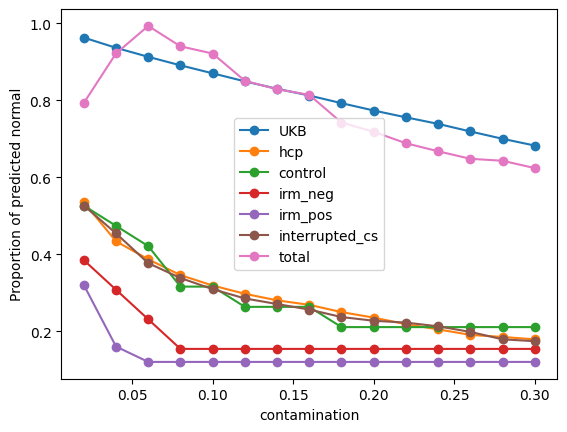

In [116]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 30D

In [117]:
reducer = umap.UMAP(n_components=30, random_state=42)
X1_umap30 = reducer.fit_transform(X_ukb)
X2_umap30 = reducer.transform(X_hcp)
X3_umap30= reducer.transform(X_control)
X4_umap30=reducer.transform(X_neg)
X5_umap30=reducer.transform(X_pos)
X6_umap30=reducer.transform(X_cs)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [118]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap30)

    y1 = clf.predict(X1_umap30)
    y2 = clf.predict(X2_umap30)
    y3 = clf.predict(X3_umap30)
    y4 = clf.predict(X4_umap30)
    y5 = clf.predict(X5_umap30)
    y6 = clf.predict(X6_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


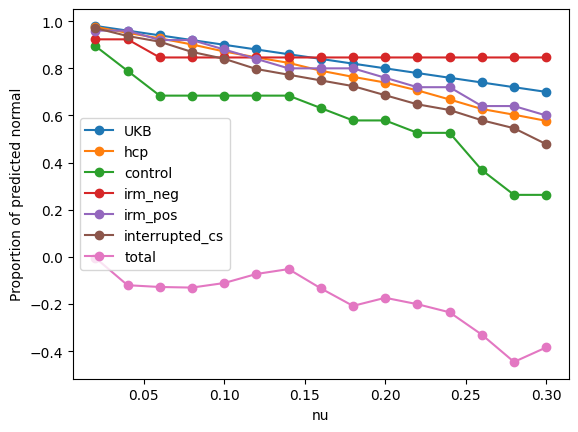

In [119]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [120]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap30)

    y1 = clf.predict(X1_umap30)
    y2 = clf.predict(X2_umap30)
    y3 = clf.predict(X3_umap30)
    y4 = clf.predict(X4_umap30)
    y5 = clf.predict(X5_umap30)
    y6 = clf.predict(X6_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)

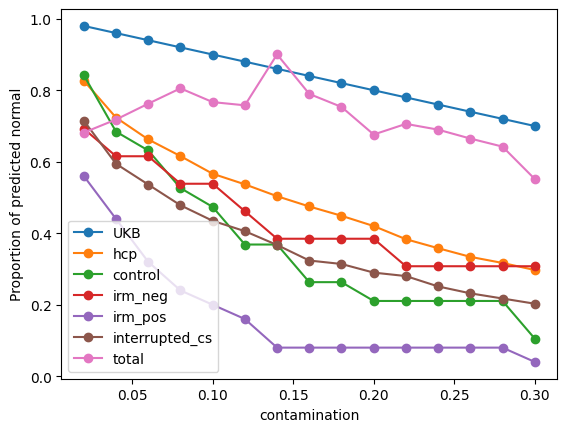

In [121]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [122]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap30)
    y1 = lof.predict(X1_umap30)
    y2 = lof.predict(X2_umap30)
    y3 = lof.predict(X3_umap30)
    y4 = lof.predict(X4_umap30)
    y5 = lof.predict(X5_umap30)
    y6 = lof.predict(X6_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


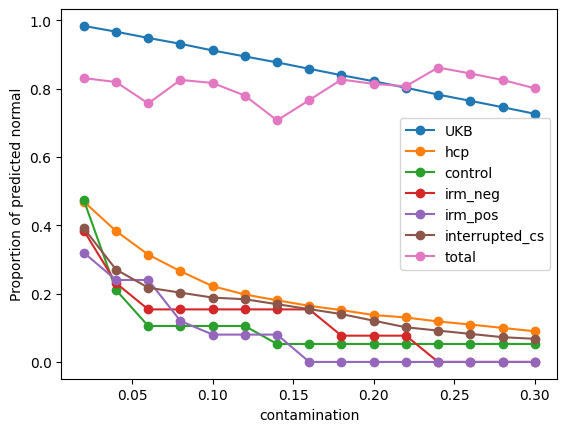

In [123]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [124]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []


for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap30)

    y1 = 1- clf.predict(X1_umap30)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap30)
    y3 = 1- clf.predict(X3_umap30)
    y4 = 1- clf.predict(X4_umap30)
    y5 = 1- clf.predict(X5_umap30)
    y6 = 1- clf.predict(X6_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


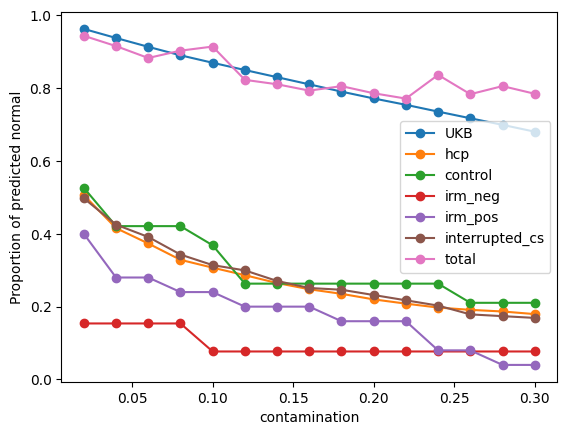

In [125]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 40D

In [126]:
reducer = umap.UMAP(n_components=40, random_state=42)
X1_umap40 = reducer.fit_transform(X_ukb)
X2_umap40 = reducer.transform(X_hcp)
X3_umap40= reducer.transform(X_control)
X4_umap40=reducer.transform(X_neg)
X5_umap40=reducer.transform(X_pos)
X6_umap40=reducer.transform(X_cs)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [127]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap40)

    y1 = clf.predict(X1_umap40)
    y2 = clf.predict(X2_umap40)
    y3 = clf.predict(X3_umap40)
    y4 = clf.predict(X4_umap40)
    y5 = clf.predict(X5_umap40)
    y6 = clf.predict(X6_umap40)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


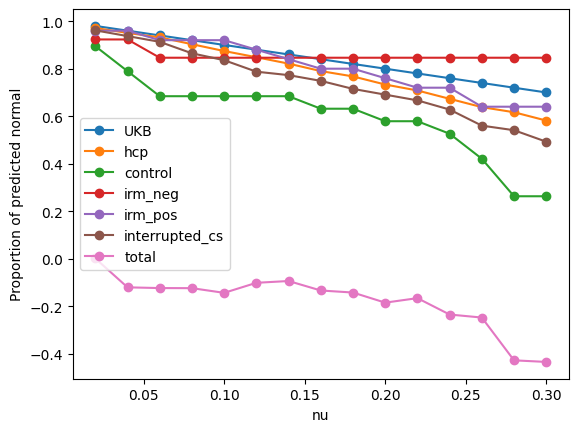

In [128]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [129]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap40)

    y1 = clf.predict(X1_umap40)
    y2 = clf.predict(X2_umap40)
    y3 = clf.predict(X3_umap40)
    y4 = clf.predict(X4_umap40)
    y5 = clf.predict(X5_umap40)
    y6 = clf.predict(X6_umap40)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)

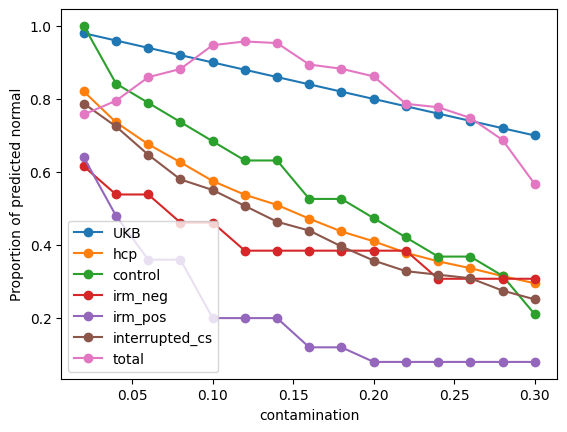

In [130]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [131]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap40)
    y1 = lof.predict(X1_umap40)
    y2 = lof.predict(X2_umap40)
    y3 = lof.predict(X3_umap40)
    y4 = lof.predict(X4_umap40)
    y5 = lof.predict(X5_umap40)
    y6 = lof.predict(X6_umap40)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


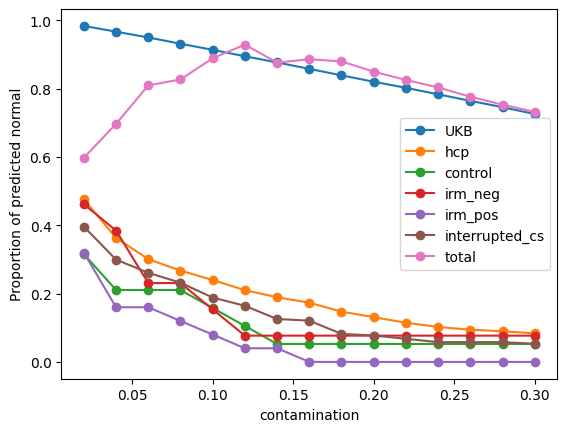

In [132]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [133]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []


for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap40)

    y1 = 1- clf.predict(X1_umap40)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap40)
    y3 = 1- clf.predict(X3_umap40)
    y4 = 1- clf.predict(X4_umap40)
    y5 = 1- clf.predict(X5_umap40)
    y6 = 1- clf.predict(X6_umap40)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


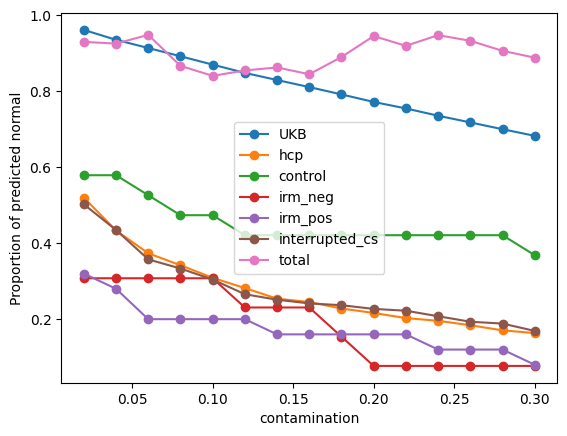

In [134]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Feature bagging

In [56]:
nu = np.arange(0.02,0.21,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

n_models = 51 
M=75 #nbres de dimensions      
subset_size = M // 2  
for u in nu:
    print(u)
    predictions_all1 = np.zeros((X_ukb.shape[0], n_models))
    predictions_all2 = np.zeros((X_hcp.shape[0], n_models))
    predictions_all3 = np.zeros((X_control.shape[0], n_models))
    predictions_all4 = np.zeros((X_PEPR.shape[0], n_models))

    for i in range(n_models):
        # Sélection aléatoire d'un sous-ensemble de features
        features_idx = np.random.choice(M, subset_size, replace=False)
        X_subset1 = X_ukb[:, features_idx]
        X_subset2 = X_hcp[:, features_idx]
        X_subset3 = X_control[:, features_idx]
        X_subset4 = X_PEPR[:, features_idx]

        clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
        clf.fit(X_subset1)
        y_pred1 = clf.predict(X_subset1)
        y_pred2 = clf.predict(X_subset2)
        y_pred3 = clf.predict(X_subset3)
        y_pred4 = clf.predict(X_subset4)

        predictions_all1[:, i] = y_pred1
        predictions_all2[:, i] = y_pred2
        predictions_all3[:, i] = y_pred3
        predictions_all4[:, i] = y_pred4

    y1 = (predictions_all1.mean(axis=1) > 0).astype(int)
    y2 = (predictions_all2.mean(axis=1) > 0).astype(int)
    y3 = (predictions_all3.mean(axis=1) > 0).astype(int)
    y4 = (predictions_all4.mean(axis=1) > 0).astype(int)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998


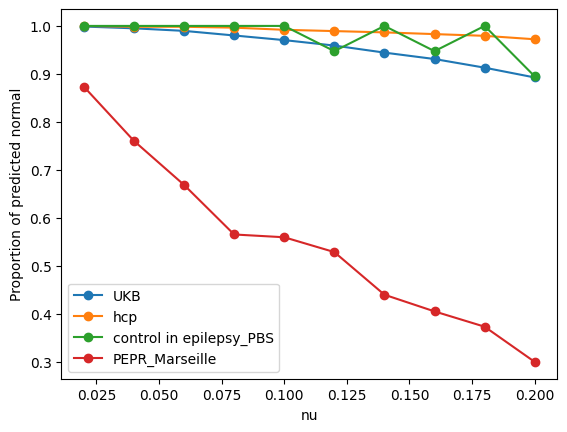

In [57]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control in epilepsy_PBS")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()